<a href="https://colab.research.google.com/github/glimmer-jm/Projects/blob/main/Hate_Speech_detection_using_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hate speech detection using DL

In today’s digital age, social media platforms have become a double-edged sword—connecting people worldwide while also serving as breeding grounds for hate speech and offensive language. As these toxic interactions proliferate, the need for automated tools to detect and mitigate them has never been more urgent. This notebook explores the power of deep learning in addressing this challenge through a natural language processing (NLP) approach. By building a sequence classification model, we aim to classify tweets into three categories—Hate Speech, Offensive Language, and Normal—leveraging cutting-edge techniques to understand and filter textual content. This project not only showcases the application of advanced NLP but also contributes to creating safer online spaces, one tweet at a time.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Text preprocessing libraries
import nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import string
import warnings
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# Tensorflow to build the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras import layers

nltk.download('stopwords')
nltk.download('wordnet')
#removed own-1.4 from nltk as it is not a valid package
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Now let's load the dataset
df= pd.read_csv('/content/drive/MyDrive/Projects Colab/Hate speech dataset.csv')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
df.shape

(24783, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


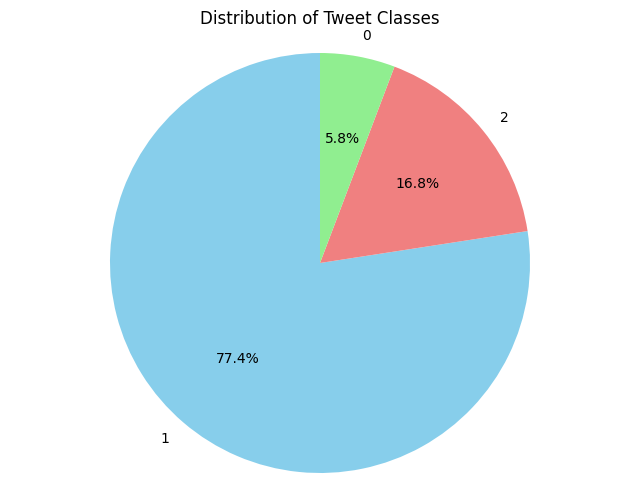

In [5]:
plt.figure(figsize=(8, 6))  # Adjust figure size
colors = ['skyblue', 'lightcoral', 'lightgreen'] # Define custom colors
plt.pie(df['class'].value_counts(), labels=df['class'].value_counts().index, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Distribution of Tweet Classes') # Add a title
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


- **Class 1** (Neither, blue): 77.4% of the tweets
- **Class 2** (Offensive Language, red): 16.8% of the tweets
- **Class 0** (Hate Speech, green): 5.8% of the tweets

So that confirms the dataset is imbalanced, with a significant majority of tweets falling into the "Neither" category (Class 1), while "Hate Speech" (Class 0) is the smallest and most underrepresented class. This imbalance could lead your deep learning model to perform poorly on detecting hate speech, as it might prioritize the majority class during training

## 1- Lowercasing and Punctuation removal

In [6]:
#Lower case all the words of the tweet before any preprocessing
df['tweet']= df['tweet'].str.lower()
#Removing punctuations present in the text
punctuations_list= string.punctuation
def remove_punctuations(text):
  for punctuation in punctuations_list:
    text= text.replace(punctuation, '')
  return text
df['tweet']= df['tweet'].apply(lambda x: remove_punctuations(x))
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rt mayasolovely as a woman you shouldnt compl...
1,1,3,0,3,0,1,rt mleew17 boy dats coldtyga dwn bad for cuff...
2,2,3,0,3,0,1,rt urkindofbrand dawg rt 80sbaby4life you eve...
3,3,3,0,2,1,1,rt cganderson vivabased she look like a tranny
4,4,6,0,6,0,1,rt shenikaroberts the shit you hear about me ...


## 2- Adding Stopwords removal

In [7]:
stopwords= set(stopwords.words('english'))
def remove_stopwords(text):
  text= [word for word in text.split() if word not in stopwords]
  return " ".join(text)
df['tweet']= df['tweet'].apply(lambda x: remove_stopwords(x))
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rt mayasolovely woman shouldnt complain cleani...
1,1,3,0,3,0,1,rt mleew17 boy dats coldtyga dwn bad cuffin da...
2,2,3,0,3,0,1,rt urkindofbrand dawg rt 80sbaby4life ever fuc...
3,3,3,0,2,1,1,rt cganderson vivabased look like tranny
4,4,6,0,6,0,1,rt shenikaroberts shit hear might true might f...


## 3- Adding lemmatization

In [8]:
lemmatizer= WordNetLemmatizer()
def lemmatize_words(text):
  return ''.join([lemmatizer.lemmatize(word)for word in text.split()])
df['tweet']= df['tweet'].apply(lambda x: lemmatize_words(x))
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rtmayasolovelywomanshouldntcomplaincleaninghou...
1,1,3,0,3,0,1,rtmleew17boydatcoldtygadwnbadcuffindathoe1stplace
2,2,3,0,3,0,1,rturkindofbranddawgrt80sbaby4lifeeverfuckbitch...
3,3,3,0,2,1,1,rtcgandersonvivabasedlookliketranny
4,4,6,0,6,0,1,rtshenikarobertsshithearmighttruemightfakerbit...


## 4- Combining all steps into a single function

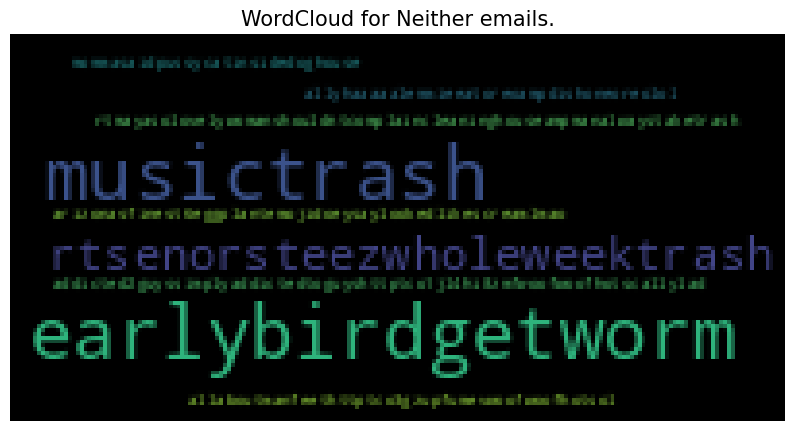

In [9]:
def plot_word_cloud(data, typ):
  # Joining all the tweets to get the corpus
  email_corpus = " ".join(data['tweet'])

  plt.figure(figsize = (10,10))

  # Forming the word cloud
  wc = WordCloud(max_words = 100,
                width = 200,
                height = 100,
                collocations = False).generate(email_corpus)

  # Plotting the wordcloud obtained above
  plt.title(f'WordCloud for {typ} emails.', fontsize = 15)
  plt.axis('off')
  plt.imshow(wc)
  plt.show()
  print()

plot_word_cloud(df[df['class']==2], typ='Neither')

In [10]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rtmayasolovelywomanshouldntcomplaincleaninghou...
1,1,3,0,3,0,1,rtmleew17boydatcoldtygadwnbadcuffindathoe1stplace
2,2,3,0,3,0,1,rturkindofbranddawgrt80sbaby4lifeeverfuckbitch...
3,3,3,0,2,1,1,rtcgandersonvivabasedlookliketranny
4,4,6,0,6,0,1,rtshenikarobertsshithearmighttruemightfakerbit...


We created a word cloud to visualize the most frequent words in the "Neither" class (Class 2) tweets, giving insights into the data. This is a great exploratory step to understand the dataset.

In [11]:
class_2 = df[df['class'] == 2]
class_1 = df[df['class'] == 1].sample(n=3500)
class_0 = df[df['class'] == 0]

balanced_df = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0)

This section of the code aims to address the class imbalance issue identified earlier, where the majority of tweets in the dataset fall into the "Neither" category (Class 1), while "Hate Speech" (Class 0) is significantly underrepresented. The goal is to create a more balanced dataset, so that the deep learning model can perform better in detecting the minority classes.

## Word2Vec Conversion

In [12]:
features = balanced_df['tweet']
target = balanced_df['class']

# split into training and test sets
X_train, X_val, Y_train, Y_val = train_test_split(features,
                                                  target,
                                                  test_size=0.2,
                                                  random_state=22)
print(X_train.shape, X_val.shape) #prints to confirm it works

(9562,) (2391,)


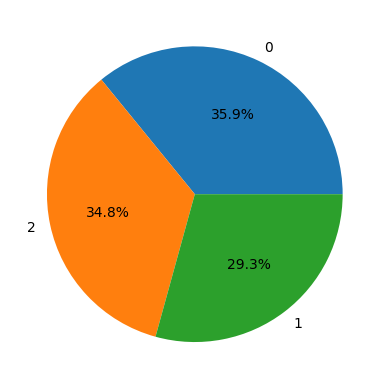

In [13]:
plt.pie(balanced_df['class'].value_counts().values,
        labels=balanced_df['class'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

In [14]:
#We have successfully divided our data into training and validation data
Y_train= pd.get_dummies(Y_train)
Y_val= pd.get_dummies(Y_val)
Y_train.shape, Y_val.shape

((9562, 3), (2391, 3))

In [15]:
max_words = 5000
max_len = 50

token = Tokenizer(num_words=max_words,
                  lower=True,
                  split=' ')

token.fit_on_texts(X_train)

In [16]:
#Generating token embeddings
training_seq = token.texts_to_sequences(X_train)
training_pad = pad_sequences(training_seq,
                             maxlen= 50,
                             padding='post',
                             truncating='post')
testing_seq = token.texts_to_sequences(X_val)
testing_pad = pad_sequences(testing_seq,
                            maxlen= 50,
                            padding='post',
                            truncating='post')

## Model Development and Evaluation
We will implement a Sequential model which will contain the following parts:

- Three Embedding Layers to learn a featured vector representations of the input vectors.
- A Bidirectional LSTM layer to identify useful patterns in the sequence.
- Then we will have one fully connected layer.
- We have included some BatchNormalization layers to enable stable and fast training and a Dropout layer before the final layer to avoid any possibility of overfitting.
- The final layer is the output layer which outputs soft probabilities for the three classes.

In [17]:
#Rebuild your model
model = keras.models.Sequential([
    layers.Embedding(max_words, 32, input_length=max_len),
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(512, activation='relu', kernel_regularizer='l1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

# Compile
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Force model building by calling build() with input shape
model.build((None, max_len))

# Now summary should work
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 32)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 32)                  │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186,755 (729.51 KB)

 Trainable params: 185,731 (725.51 KB)

 Non-trainable params: 1,024 (4.00 KB)

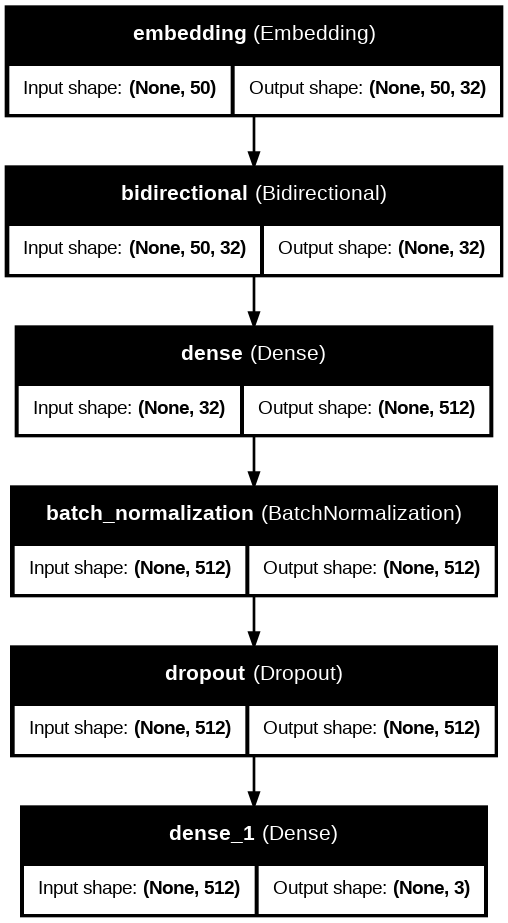

In [18]:
model.build((None, max_len))

keras.utils.plot_model(model,
                       to_file='model.png',
                       show_shapes=True,
                       show_layer_names=True,
                       rankdir='TB',
                       expand_nested=True,
                       dpi=96)

In [19]:
from re import VERBOSE
#Callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_accuracy',
                   restore_best_weights= True,
                   patience=3)
lr= ReduceLROnPlateau(monitor='val_loss',
                      verbose= 0,
                      factor=0.5,
                      patience=2)

In [23]:
# Callbacks for training
lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max')
history = model.fit(training_pad, Y_train,
                    validation_data=(testing_pad, Y_val),
                    epochs=50,
                    verbose=1,
                    batch_size=32,
                    callbacks=[lr])

Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7136 - loss: 0.4880 - val_accuracy: 0.5939 - val_loss: 0.7612 - learning_rate: 2.5000e-04
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.7789 - loss: 0.4602 - val_accuracy: 0.5926 - val_loss: 0.8667 - learning_rate: 2.5000e-04
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8373 - loss: 0.3883 - val_accuracy: 0.6407 - val_loss: 0.8791 - learning_rate: 2.5000e-04
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8556 - loss: 0.3507 - val_accuracy: 0.6407 - val_loss: 1.0898 - learning_rate: 2.5000e-04
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.8554 - loss: 0.3389 - val_accuracy: 0.5939 - val_loss: 0.9560 - learning_rate: 1.2500e-04
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8604 - loss: 0.3252 - val_accuracy: 0.5939 - val_loss: 0.8736 - learning_rate: 1.2500e-04
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - a

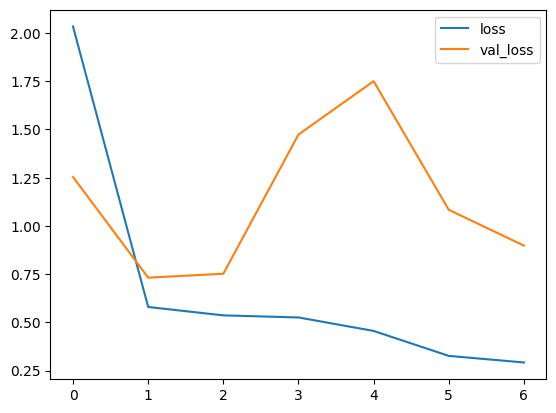

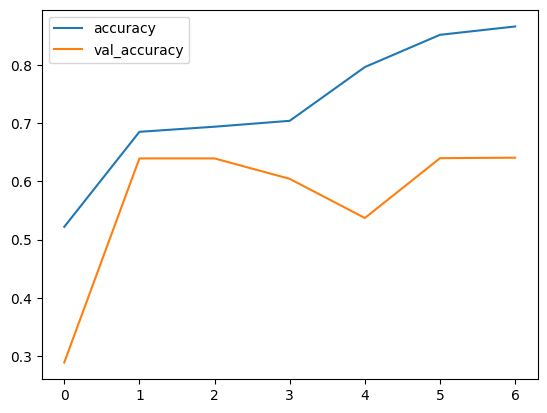

In [21]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()